<a href="https://colab.research.google.com/github/chillMLguy/ML24-25L/blob/main/HW9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Praca domowa nr 9**

###Import bibliotek i danych

In [8]:
import torch
import torchvision
import matplotlib.pyplot as plt

transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)


###Trenowanie modelu (kod z zajęć)

In [9]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = torch.nn.Sequential(   #Sequential is a structure which allows stacking layers one on another in such a way,
                                          #that output from a preceding layer serves as input to the next layer
            torch.nn.Flatten(),   #change the last three orders in data (with dimensions 1, 28 and 28 respectively) into one order of dimensions (1*28*28)
            torch.nn.Linear(1*28*28, 1024),  #which is used as INPUT to the first Linear layer
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 2048),   #IMPORTANT! Please observe, that the OUTPUT dimension of a preceding layer is always equal to the INPUT dimension of the next layer.
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 256),
            torch.nn.ReLU(),            #ReLU (or a Sigmoid if you want) is a nonlinear function which is used in-between layers
            torch.nn.Linear(256, 10),
        )
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        x = self.mlp(x)
        x = self.dropout(x)
        return x

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = MLP().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(8):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        #batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear
                                            #and MLP doesn't apply
                                            #the nonlinear activation after the last layer
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

Working on cpu
epoch: 0 batch: 0 current batch loss: 2.3052704334259033
epoch: 0 batch: 1 current batch loss: 2.0590157508850098
epoch: 0 batch: 2 current batch loss: 1.6078300476074219
epoch: 0 batch: 3 current batch loss: 1.1155316829681396
epoch: 0 batch: 4 current batch loss: 1.1064223051071167
epoch: 0 batch: 5 current batch loss: 0.9720554947853088
epoch: 0 batch: 6 current batch loss: 0.9607852697372437
epoch: 0 batch: 7 current batch loss: 1.0158313512802124
epoch: 0 batch: 8 current batch loss: 0.7509363293647766
epoch: 0 batch: 9 current batch loss: 0.6358792781829834
epoch: 0 batch: 10 current batch loss: 0.6367576122283936
epoch: 0 batch: 11 current batch loss: 0.6453750133514404
epoch: 0 batch: 12 current batch loss: 0.5852616429328918
epoch: 0 batch: 13 current batch loss: 0.4505901634693146
epoch: 0 batch: 14 current batch loss: 0.46422529220581055
epoch: 0 batch: 15 current batch loss: 0.4817066788673401
epoch: 0 batch: 16 current batch loss: 0.4421568214893341
epoch: 0

In [12]:
good = 0
wrong = 0

net.eval()
with torch.no_grad():
    for batch, data in enumerate(testloader):
        datapoint, label = data

        prediction = net(datapoint.to(device))
        classification = torch.argmax(prediction)

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))


accuracy =  0.9835


### Funkcje:

dream() - do zadania 1 i 3

dream _multiple_digits() - do zadania 2

In [30]:
def dream(model, device, lambda_l2=0, steps=100, lr=0.1):
    model.eval()
    targets = torch.arange(10).to(device)
    dreamed_inputs = torch.randn(10, 1, 28, 28, requires_grad=True, device=device)
    optimizer = torch.optim.Adam([dreamed_inputs], lr=lr)

    loss_values = []
    confidence_values = []

    for step in range(steps):
        optimizer.zero_grad()
        outputs = model(dreamed_inputs)

        probs = torch.nn.functional.softmax(outputs, dim=1)
        confidences = probs[range(10), targets]
        confidence_values.append(confidences.mean().item())

        loss = torch.nn.functional.cross_entropy(outputs, targets) +lambda_l2 * dreamed_inputs.pow(2).mean()

        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
        dreamed_inputs.data.clamp_(-1.5, 1.5)

    #obrazy końcowe
    with torch.no_grad():
        for i in range(10):
            plt.subplot(2, 5, i + 1)
            plt.imshow(dreamed_inputs[i][0].cpu(), cmap='gray')
            plt.title(f"Digit {i}")
            plt.axis("off")
        plt.suptitle(f"Sen z regularyzacją, lambda={lambda_l2}")
        plt.tight_layout()
        plt.show()

    #confidence
    plt.plot(confidence_values)
    plt.title(f"Confidence z regularyzacją, lambda = {lambda_l2})")
    plt.xlabel("Krok")
    plt.ylabel("Confidence")
    plt.grid(True)
    plt.show()

    return dreamed_inputs, confidence_values



def dream_multiple_digits(model, device, combinations, steps=100, lr=0.1):
    model.eval()
    dreamed_inputs = torch.randn(len(combinations), 1, 28, 28, requires_grad=True, device=device)
    optimizer = torch.optim.Adam([dreamed_inputs], lr=lr)
    confidence_values = []

    for step in range(steps):
        optimizer.zero_grad()
        outputs = model(dreamed_inputs)

        loss = 0.0
        batch_confidences = []

        for i, (a, b) in enumerate(combinations):
            probs = torch.nn.functional.softmax(outputs[i], dim=0)
            confidence = probs[a] + probs[b]
            batch_confidences.append(confidence.item() / 2.0)

            log_probs = torch.nn.functional.log_softmax(outputs[i], dim=0)
            mixed_loss = -0.5 * (log_probs[a] + log_probs[b])
            loss += mixed_loss

        confidence_values.append(sum(batch_confidences) / len(batch_confidences))
        loss.backward()
        optimizer.step()
        dreamed_inputs.data.clamp_(-1.5, 1.5)

    #wizualizacja wyniku
    with torch.no_grad():
        for i, (a, b) in enumerate(combinations):
            plt.subplot(2, 5, i + 1)
            plt.imshow(dreamed_inputs[i][0].cpu(), cmap='gray')
            plt.title(f"{a} + {b}")
            plt.axis("off")
        plt.suptitle("Połączone dwie liczby")
        plt.tight_layout()
        plt.show()

    #confidence
    plt.plot(confidence_values)
    plt.title("Średni confidence dla dwóch klas")
    plt.xlabel("Krok")
    plt.ylabel("Confidence")
    plt.grid(True)
    plt.show()

    return dreamed_inputs, confidence_values


### Testowanie i konkluzje

### Task 1

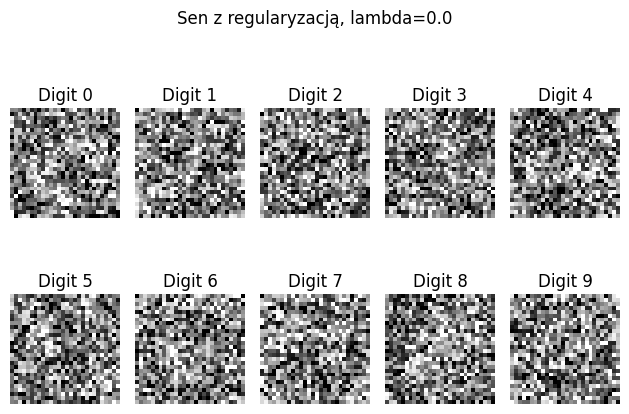

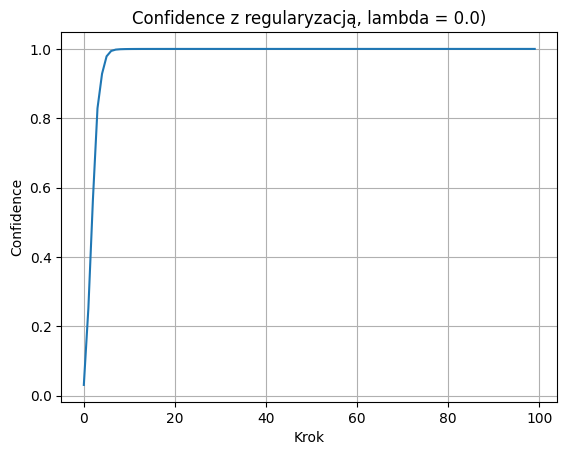

In [33]:
# TASK 1, lambda - 0
dreamed_task1, conf1 = dream(
    model=net,
    device=device,
    lambda_l2=0.0,
    steps=100,
    lr=0.05
)

### Wniosek do taska 1:

Wygenerowane obrazy nie przypominają prawdziwych cyfr z MNIST – są mocno zaszumione i nienaturalne. Dzieje się tak, ponieważ sieć uczy się poniekąd oszukiwać siebie i znajduje takie wzorce, które są dla niej wystarczające do klasyfikacji, ale dla człowieka nie mają sensu wizualnego. Model nie musi generować realistycznych cyfr, tylko takie, które uruchamiają odpowiednie neurony.

### Task 2

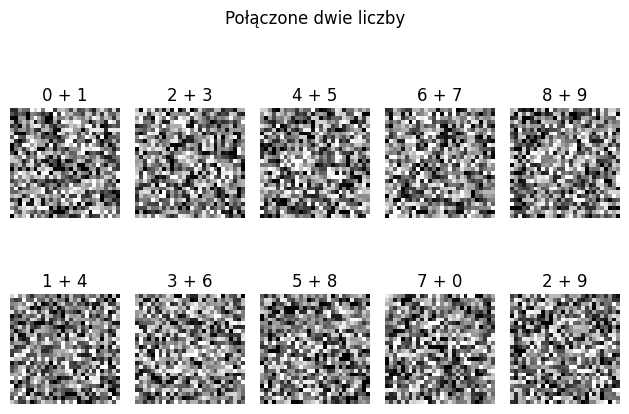

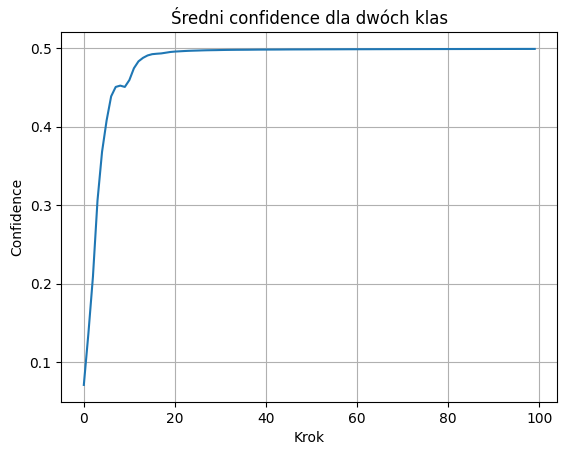

In [36]:
# TASK 2, łączenie dwóch liczb
combinations = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9),
                (1, 4), (3, 6), (5, 8), (7, 0), (2, 9)]

dreamed_task2, conf2 = dream_multiple_digits(
    model=net,
    device=device,
    combinations=combinations,
    steps=100,
    lr=0.05
)

### Wniosek do taska 2:

Podszedłem do problemu tak, że zamiast jednej etykiety docelowej dla każdego obrazu, przypisałem dwie cyfry jednocześnie. W trakcie optymalizacji starałem się tak modyfikować obraz, żeby model przypisywał wysokie prawdopodobieństwo obu klasom naraz przez maksymalizacje średniego logarytmu prawdopodobieństw dla dwóhc liczb. Dzięki temu uzyskałem obrazy, które przypominają połączenie dwóch cyfr (oczywiście przypominają je sieci)– np. coś pomiędzy 3 a 8.

### Task 3

--- λ = 0.001 ---


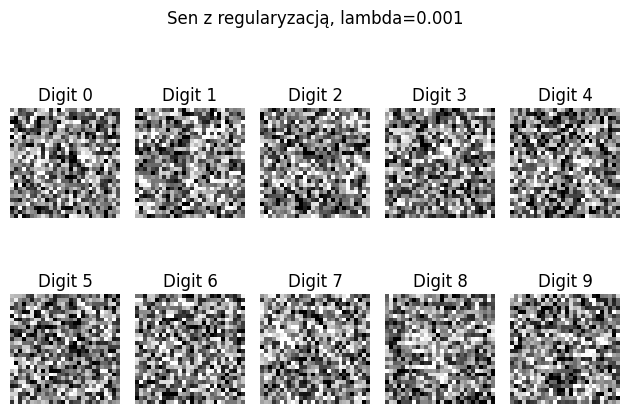

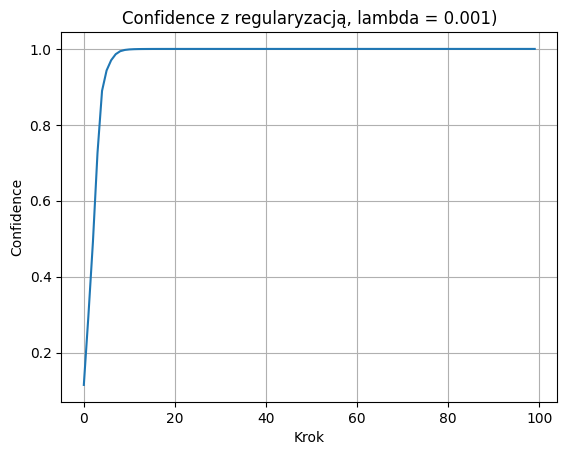

--- λ = 0.01 ---


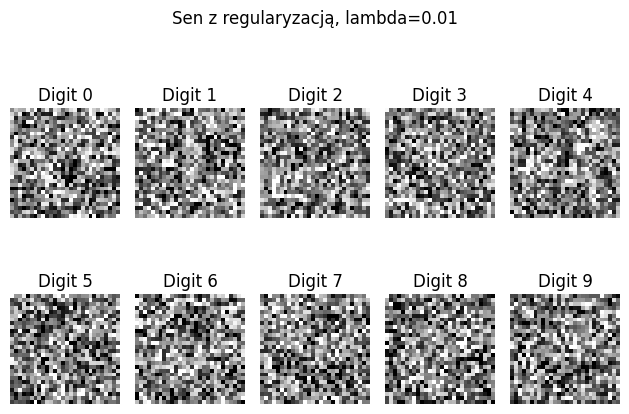

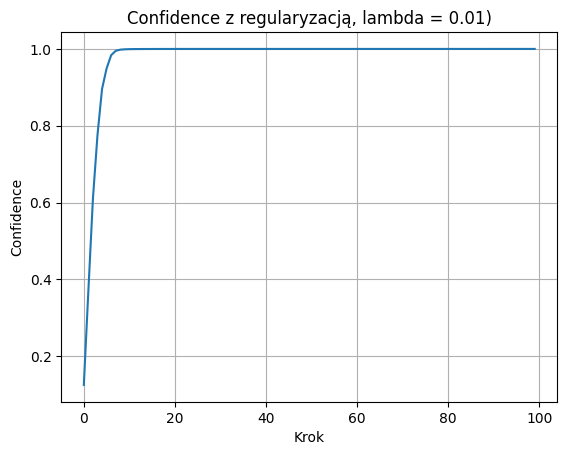

--- λ = 0.1 ---


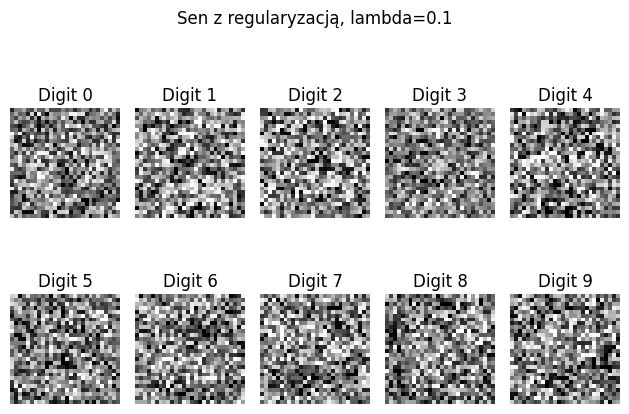

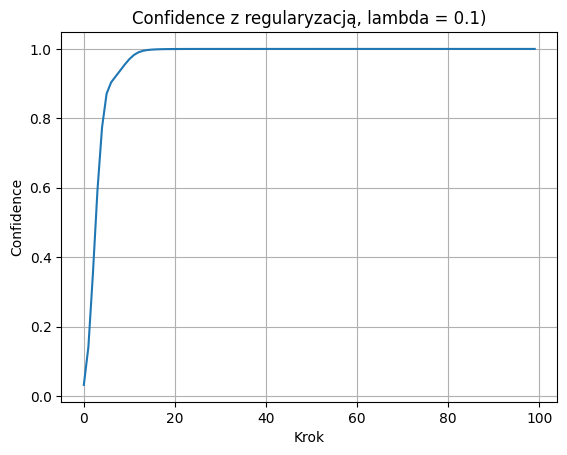

--- λ = 1.0 ---


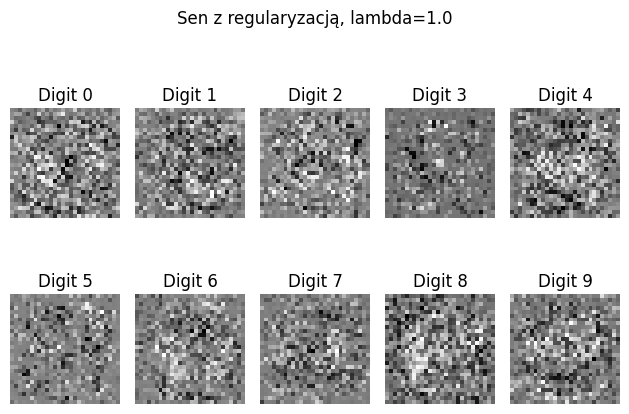

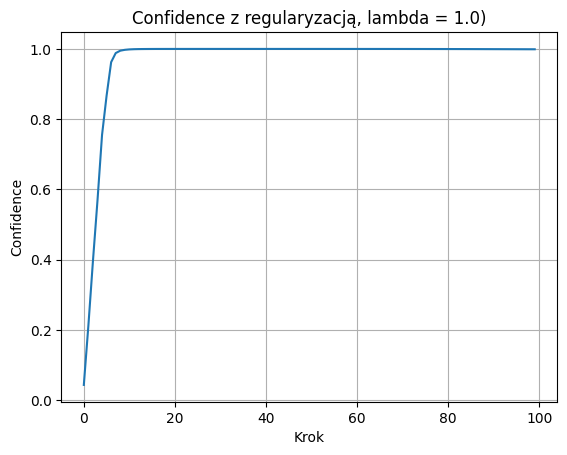

--- λ = 10.0 ---


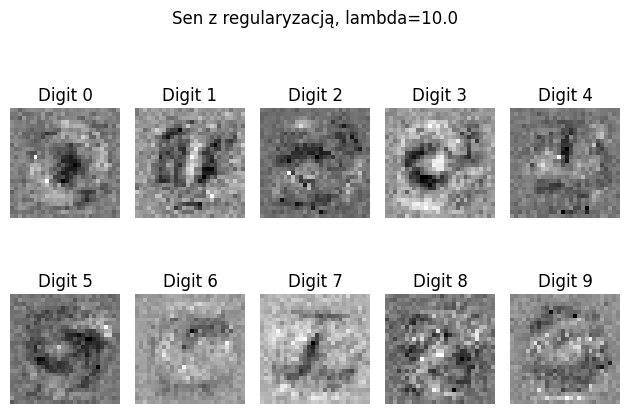

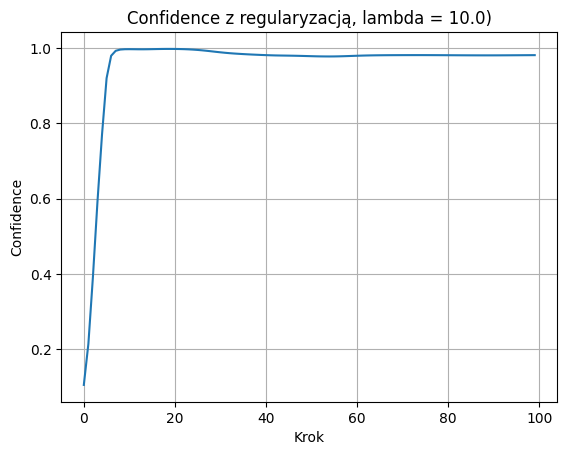

In [35]:
#TASK 3, różne lambda

lambdas = [0.001, 0.01, 0.1, 1.0, 10.0]
all_confidences = []

for lam in lambdas:
    print(f"--- λ = {lam} ---")
    dreamed_img, conf = dream(
        model=net,
        device=device,
        lambda_l2=lam,
        steps=100,
        lr=0.05
    )
    all_confidences.append((lam, conf))

### Wniosek do taska 3:

Tak, nowe cyfry są rozpoznawane poprawnie, ale ich wygląd zależy od siły kary. Przy małej wartości obrazy są nadal bardzo zaszumione, ale gdy zwiększamy karę, cyfry stają się gładsze i bardziej czytelne. Zbyt duża kara sprawia jednak, że obrazy zaczynają się rozmywać, a model traci pewność klasyfikacji. Kara L2 działa więc jak filtr – redukuje szum, ale może też tłumić użyteczne cechy.